In [1]:
import os
from pylab import *
import pandas as pd
import numpy as np
import scipy
from scipy import io, stats
import matplotlib.pyplot as plt
os.chdir('/Users/franciscojavierarceo/GitHub/EECS6892/')
%matplotlib inline  
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
# Reading the data and storing it in a dictionary
data = {}
for letter in ("X", "y", "z"):
    for number in (1,2,3):
        data["%s%d" % (letter, number)] = pd.read_csv('data_csv/%s_set%d.csv' % (letter, number), header=None).values

In [3]:
# Function to extract data
def pulldata(data,num):
    x = data['X%s' % (num)]
    y = data['y%s' % (num)]
    z = data['z%s' % (num)]
    return x,y,z

In [38]:
# Extract the dataset based on index
x,y,z = pulldata(data,1)

In [5]:
gammaln = scipy.special.gammaln
psi = scipy.special.psi 

def updateVR(x,y,n,d,sumxixi_t,sum_yixi,a_0,b_0,e_0,f_0,mu_0,sigma_0):
    xsigmax = yminusxTmu = 0
    for i in range(n):
        xi = x[i].reshape(1,d)
        xsigmax += xi.dot(sigma_0).dot(xi.T)
        yminusxTmu += (y[i]-xi.dot(mu_0) )**2
    a_1 = a_0 + 0.5
    b_1 = np.ones((d,1))
    for j in range(d):
        b_1[j] = b_0[j] + 0.5*(sigma_0[j][j] + mu_0[j]**2)
    e_1 = e_0 + float(n)/2.0
    f_1 = f_0 + 0.5*( yminusxTmu +xsigmax)
    sigma_1 = np.linalg.inv( (e_1 / f_1)*sumxixi_t+np.diagflat(a_1/b_1) )
    mu_1 =  sigma_1.dot( (e_1/f_1) *sum_yixi )
    err = np.sum( np.abs(y - x.dot(mu_1)))
    VarObj_Func = Varational_Obj_Func(x,y,a_1,b_1,e_1,f_1,mu_1,sigma_1,xsigmax)
    return a_1, b_1, e_1, f_1, mu_1, sigma_1, err, VarObj_Func

def IterateVR(x,y,T):
    n, d = x.shape
    psi = scipy.special.psi
    gamfunc = scipy.special.gamma
    abserr = np.zeros((T,1))
    vrtnl_obj = np.zeros((T,1))
    # Calculating this stuff only once
    sum_yixi = np.zeros((d,1))
    sumxixi_t = np.zeros((d,d))
    for i,xi in enumerate(x):
        xi = xi.reshape((d,1))
        sumxixi_t += xi.dot(xi.T)
        sum_yixi+= y[i]*xi
    # Initializing all of the values
    mu_0 = np.ones((d,1))
    sigma_0 = np.ones((d,d))
    a_0 = b_0 = np.ones((d,1)) * 10e-16
    e_0 = f_0 = 1
    for t in xrange(T):
        if ((t+1) %100)==0:
            print "Iteration "+str(t+1) + " Complete"
        a_1, b_1, e_1, f_1, mu_1, sigma_1, err, vof = updateVR(x,y,n,d,sumxixi_t,sum_yixi,a_0,b_0,e_0,f_0,mu_0,sigma_0)
        abserr[t] = err
        vrtnl_obj[t] = vof
        a_0 =a_1; b_0=b_1; e_0=e_1 ; f_0=f_1 ; mu_0=mu_1 ; sigma_0=sigma_1
    print "*"*50, "\n Variational Regression Complete \n", "*"*50
    return a_1, b_1, e_1, f_1, mu_1, abserr,  vrtnl_obj 

def Varational_Obj_Func(x,y,a_1,b_1,e_1,f_1,mu_1,sigma_1,xsigmax):
    n,d = x.shape
    a_0 = b_0= np.ones((d,1))*10e-16
    e_0 = f_0 = 1
    Eln_qw = 0.5*np.log(np.linalg.det(sigma_1))
    Eln_qlambda = e_1-np.log(f_1)+gammaln(e_1)+(1.0-e_1)*psi(e_1)
    Eln_qalpha = np.sum(a_1-np.log(b_1)+gammaln(a_1)+(1.0-a_1)*psi(a_1))
    diag_ab = np.diagflat(a_1/b_1)
    Eln_pw=0.5*np.sum(psi(a_1)-np.log(b_1))-0.5*np.trace(diag_ab.dot(sigma_1))-0.5*mu_1.T.dot(diag_ab).dot(mu_1) 
    Eln_plambda = (e_0-1.0)*(psi(e_1)-np.log(f_1))-f_0*(e_1/f_1)
    Eln_palpha = np.sum((a_0-1.0)*(psi(a_1)-np.log(b_1))-b_0*(a_1/b_1))
    yminusxTmu = 0
    for i in range(n):
        yminusxTmu += (y[i]-x[i].dot(mu_1) )**2
    Eln_py=float(n)/2.0*(psi(e_1)-np.log(f_1))-0.5*(e_1/f_1)*(yminusxTmu+xsigmax)
    VarObj_Func = Eln_plambda+Eln_pw+Eln_palpha+Eln_py-Eln_qlambda-Eln_qw-Eln_qalpha
    return VarObj_Func

In [6]:
a_1, b_1, e_1, f_1,  mu_1, abserr, VarObj_Func = IterateVR(x,y,500)

Iteration 100 Complete
Iteration 200 Complete
Iteration 300 Complete
Iteration 400 Complete
Iteration 500 Complete
************************************************** 
 Variational Regression Complete 
**************************************************


In [7]:
def plotVarObjFunc(VarObj_Func):
    # Part A
    myplot = plt.figure()
    plt.plot(VarObj_Func)
    plt.title('Variational Objective Function across iterations')
    plt.grid()
    myplot.savefig('HMWK3_Q2_A.png')

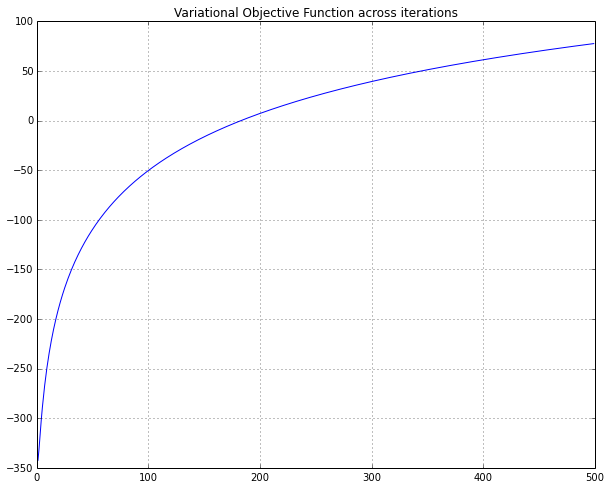

In [8]:
plotVarObjFunc(VarObj_Func)

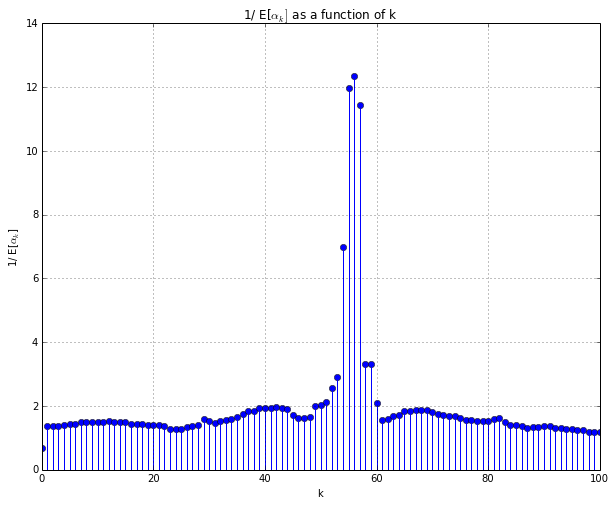

In [43]:
# Part B
def plot1overalpha(alpha):
    myplot = plt.figure()
    plt.stem( 1/alpha )
    plt.title(r'1/ E[$\alpha_k]$ as a function of k')
    plt.grid()
    plt.xlabel('k')
    plt.ylabel(r'1/ E[$\alpha_k$]')
    myplot.savefig('HMWK3_Q2_B.png')

plot1overalpha( a_1 / b_1)

In [ ]:
# Part C
print "1/E[\lambda] =", float(f_1 / e_1)

In [34]:
# Part D
def plot_xzymu(x,y,z,mu_1):    
    yhat = x.dot(mu_1)
    z_n = np.linspace(-6,6,len(y))
    fz_n = 10 * np.sinc(z_n)
    plt.plot(z,yhat,color='red',label='Predicted')
    plt.scatter(z,y,color='green',label='Actual')
    plt.plot(z_n,fz_n,label='True')
    plt.legend()
    plt.title('Actual, Predicted, and True function')
    plt.grid()

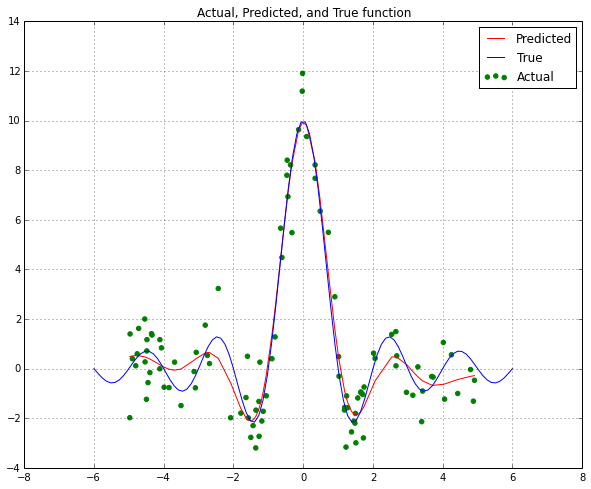

In [42]:
plot_xzymu(x,y,z,mu_1)

In [ ]:
plt.plot(abserr)

In [ ]:
!ipython nbconvert EECS6892_HMWK3-FJA.ipynb --to python

In [41]:
for i in range(3):
    print i

0
1
2
